Example from https://github.com/qiskit-community/qiskit-nature-pyscf

In [1]:
from pyscf import gto, scf, mcscf, fci # pyscf = (classical) python-based simulations of chemistry framework

# gto.M defines molecular geometry & basis set
# scf.RHF restricted Hartree-Fock
# mcscf.CASCI complete active space configuration interaction

import numpy as np
import matplotlib.pyplot as plt

from qiskit.primitives import Estimator # expectation values
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.mappers import ParityMapper

from qiskit_nature_pyscf import QiskitSolver

In [2]:
def create_molecule(bond_length):
    """ Function to create a LiH molecule given a bond length"""
    return gto.M(
        atom=f"Li 0 0 0; H 0 0 {bond_length}", basis="sto-3g"
    ) 

In [3]:
# LiH molecule created with STO-3G basis set
# Li positioned at (0,0,0), H at (0,0,1.6) atomic units
mol = create_molecule(1.6)

In [4]:
# Define constants
norb = 5 # Number of active orbitals
nalpha, nbeta = 1, 1 # One alpha (spin up) and one beta (spin down) electron
nelec = nalpha + nbeta # Two valence electrons total

In [5]:
# runs Restricted Hartree-Fock to get molecular orbitals and reference (HF) energy (from mean-field approx)
h_f = scf.RHF(mol).run()
energy_hf = h_f.e_tot

converged SCF energy = -7.86186476980865


In [ ]:
def run_vqe(h_f):
    """prepare a quantum computing-based method to solve the electronic structure problem."""
    mapper = ParityMapper(num_particles=(nalpha, nbeta))
    # maps the fermionic Hamiltonian to a qubit Hamiltonian
    # dual of Jordan-Wigner mapping
    # allows to reduce no. of qubits in certain cases
    
    ansatz = UCCSD( # Unitary Coupled Cluster with Single and Double excitations (trial wavefunction)
        norb,
        (nalpha, nbeta),
        mapper,
        initial_state=HartreeFock(
            norb,
            (nalpha, nbeta),
            mapper,
        ),
    )
    # list of predefined  ansatzes: https://qiskit-community.github.io/qiskit-nature/apidocs/qiskit_nature.second_q.circuit.library.html
    
    vqe = VQE(Estimator(), ansatz, SLSQP()) 
    # to minimise the ground-state energy using classical Sequential Least Squares Programming optimisation
    # list of optimizers: https://qiskit-community.github.io/qiskit-algorithms/apidocs/qiskit_algorithms.optimizers.html
    
    vqe.initial_point = np.zeros(ansatz.num_parameters)
    
    algorithm = GroundStateEigensolver(mapper, vqe)

    cas = mcscf.CASCI(h_f, norb, nelec) # selects active orbitals and electrons
    cas.fcisolver = QiskitSolver(algorithm)
    #replaces the default FCI solver in PySCF with the VQE-based quantum solver
    
    cas.run()
    return cas.e_tot

In [7]:
energy_vqe = run_vqe(h_f)

/var/folders/x9/wfb287qn00v442vdfjd74t680000gq/T/ipykernel_7263/2233199785.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe = VQE(Estimator(), ansatz, SLSQP())


CASCI E = -7.88209648910108  E(CI) = -1.07808419079903


In [8]:
def run_fci(h_f):
    """run a fci calculation for a benchmark"""
    cisolver = fci.FCI(h_f)
    cisolver = cisolver.run()
    return cisolver.e_tot

In [9]:
energy_fci = run_fci(h_f)

In [10]:
# Comparison of methods
print("VQE Energy:", energy_vqe)
print("FCI Energy:", energy_fci)

VQE Energy: -7.8820964891010785
FCI Energy: -7.882324378883491


## Output

Converged SCF energy = Hartree-Fock energy, in Hartrees, from mean-field approximation, ignoring electron correlation.

CASCI E = Complete Active Space Configuration Interaction (CASCI) energy.
CASCI improves upon HF by allowing a full CI expansion within the active space (selected orbitals/electrons).
Since CASCI includes static correlation effects, it should always be lower (more negative) than the SCF energy.

## Bond stretching workflow

In [ ]:
bond_lengths = np.linspace(1.4, 1.7, 4)

h_f_energies = []
vqe_energies = []
fci_energies = []

for bond_length in bond_lengths:
    mol = create_molecule(bond_length)
    h_f = scf.RHF(mol).run()
    h_f_energies.append(h_f.e_tot)
    vqe_energies.append(run_vqe(h_f))
    fci_energies.append(run_fci(h_f))
    

converged SCF energy = -7.86053866102113


/var/folders/x9/wfb287qn00v442vdfjd74t680000gq/T/ipykernel_7263/2233199785.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe = VQE(Estimator(), ansatz, SLSQP())


CASCI E = -7.87823057504728  E(CI) = -1.12139025732304
converged SCF energy = -7.86335762153511
CASCI E = -7.88213985596634  E(CI) = -1.10018822901209
converged SCF energy = -7.86186476980865
CASCI E = -7.88209648945639  E(CI) = -1.07808419115435
converged SCF energy = -7.85714496020382


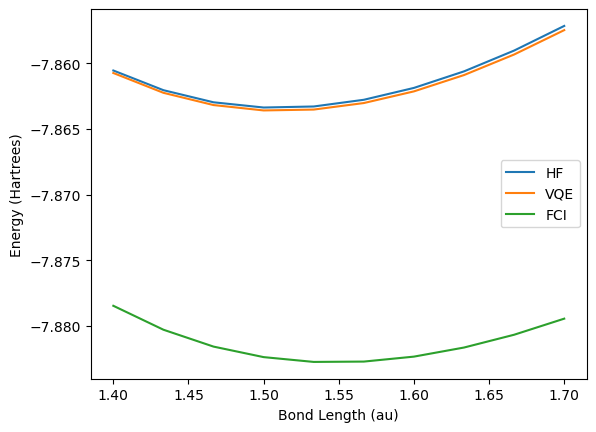

In [ ]:
plt.plot(bond_lengths, h_f_energies, label="HF")
plt.plot(bond_lengths, vqe_energies, label="VQE")
plt.plot(bond_lengths, fci_energies, label="FCI")
plt.xlabel("Bond Length (au)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
plt.show()